
<h1><center>Generative models</center></h1>

# PixelCNN: A Generative Model
PixelCNN is a type of autoregressive generative model developed for modeling images. It captures the dependencies between pixels, allowing it to generate new images pixel by pixel. Unlike traditional generative models, PixelCNN models the conditional distribution of each pixel given the previous ones.


## Autoregressive Models
Autoregressive models aim to predict the next element in a sequence based on prior elements. In the context of images, PixelCNN models the probability distribution of each pixel given all previous pixels in raster order (top to bottom, left to right). This enables generating images from scratch.

The key idea of PixelCNN is to factor the image's joint distribution into a product of conditional distributions:
$$ P(x) = \prod_i P(x_i | x_{1:i-1}) $$

Where each pixel is conditioned on the previous pixels.


## PixelCNN Architecture
PixelCNN uses a stack of convolutional layers where each layer is masked to ensure that the pixel at position (i, j) only depends on previous pixels. The network models the conditional probability of a pixel given its neighbors.

The structure can be visualized as:

![PixelCNN Architecture](https://camo.githubusercontent.com/2f581257c289298057989d11aa1ad507c2af397b2471c592f7b17a5dbecd731e/687474703a2f2f736572676569747572756b696e2e636f6d2f6173736574732f323031372d30322d32322d3138333031305f343739783439345f7363726f742e706e67)  <!-- Add actual image reference here -->


## PixelCNN Architecture
PixelCNN uses a stack of convolutional layers where each layer is masked to ensure that the pixel at position (i, j) only depends on previous pixels. The network models the conditional probability of a pixel given its neighbors.

The structure can be visualized as:

![PixelCNN Architecture](https://camo.githubusercontent.com/2b432c6d87633c75685c3703167c0a6b5a6d6592a7ca95540bf02f6de890052c/68747470733a2f2f6c696c69616e77656e672e6769746875622e696f2f6c696c2d6c6f672f6173736574732f696d616765732f706978656c2d636e6e2e706e67)  <!-- Add actual image reference here -->


## Masked Convolutions
PixelCNN employs masked convolutions to ensure that future pixels are not used in the computation of the current pixel's distribution. There are two types of masks:

- **Mask A**
- **Mask B**

This technique helps preserve the autoregressive nature of the model.


## Implementation

PyTorch buffers are tensor attributes associated with a PyTorch module or model similar to parameters, but unlike parameters, buffers are not updated during training.



### Prepare dataset

In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


class BinaryTransform(object):
    def __init__(self, threshold=0.5):
        self.toTensor = transforms.ToTensor()
        self.threshold = threshold

    def __call__(self, sample):
        sample = self.toTensor(sample)
        sample[sample >= self.threshold] = 1
        sample[sample < self.threshold] = 0
        return sample

train_dataset = datasets.MNIST(root='./data', train=True, transform=BinaryTransform(), download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=BinaryTransform(), download=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Model implementation

    Mask type A sets the central pixel of the convolution operation to 0, while a type B mask sets it to 1.


In [ ]:
import torch
import torch.nn as nn


class MaskedConv2d(nn.Conv2d):
    """
    Class extending nn.Conv2d to use masks.
    """
    def __init__(self, mask_type, in_channels, out_channels, kernel_size, padding=0):
        super(MaskedConv2d, self).__init__(in_channels, out_channels, kernel_size, padding=padding)

        mask = torch.ones(kernel_size, kernel_size)
        k = (kernel_size + 1) // 2 - 1
        if mask_type == 'A':
            mask[k, k:] = 0
            mask[k + 1:, :] = 0
        elif mask_type == 'B':
            mask[k, k:] = 0
            mask[k + 1:, :] = 0
            mask[k, k] = 1
        else:
            raise 'mask_type must be A or B'
        self.register_buffer('mask', mask)

    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)



class PixelCNN(nn.Module):
    def __init__(self, in_channels=1, h_channels=64):
        super(PixelCNN, self).__init__()
        self.in_channels = in_channels
        self.h_channels = h_channels

        self.convs = nn.Sequential(
            MaskedConv2d('A', in_channels, h_channels, kernel_size=7, padding=3), nn.ReLU(),

            MaskedConv2d('B', h_channels, h_channels, kernel_size=7, padding=3), nn.ReLU(),
            MaskedConv2d('B', h_channels, h_channels, kernel_size=7, padding=3), nn.ReLU(),
            MaskedConv2d('B', h_channels, h_channels, kernel_size=7, padding=3), nn.ReLU(),
            MaskedConv2d('B', h_channels, h_channels, kernel_size=7, padding=3), nn.ReLU(),
            MaskedConv2d('B', h_channels, h_channels, kernel_size=7, padding=3), nn.ReLU(),

            MaskedConv2d('B', h_channels, h_channels, kernel_size=1), nn.ReLU(),
            MaskedConv2d('B', h_channels, 1, kernel_size=1),

            nn.Sigmoid()
        )

    def forward(self, x):
        return self.convs(x)

    def name(self):
        return f'PixelCNN_inC{self.in_channels}_hC{self.h_channels}'

### Training

In [ ]:
!pip install torchinfo -q

In [ ]:
from torchinfo import summary
n_epochs = 5
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = PixelCNN()
model= model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = torch.nn.BCELoss()

print(summary(model))

Layer (type:depth-idx)                   Param #
PixelCNN                                 --
├─Sequential: 1-1                        --
│    └─MaskedConv2d: 2-1                 3,200
│    └─ReLU: 2-2                         --
│    └─MaskedConv2d: 2-3                 200,768
│    └─ReLU: 2-4                         --
│    └─MaskedConv2d: 2-5                 200,768
│    └─ReLU: 2-6                         --
│    └─MaskedConv2d: 2-7                 200,768
│    └─ReLU: 2-8                         --
│    └─MaskedConv2d: 2-9                 200,768
│    └─ReLU: 2-10                        --
│    └─MaskedConv2d: 2-11                200,768
│    └─ReLU: 2-12                        --
│    └─MaskedConv2d: 2-13                4,160
│    └─ReLU: 2-14                        --
│    └─MaskedConv2d: 2-15                65
│    └─Sigmoid: 2-16                     --
Total params: 1,011,265
Trainable params: 1,011,265
Non-trainable params: 0


In [ ]:
from tqdm import tqdm

def train_epoch(model, dataloader, criterion, optimizer, device, bar_desc='Training', display_bar=True):
    model.train()
    if display_bar:
        bar = tqdm(total=len(dataloader), desc=bar_desc, postfix='', leave=True, position=0)

    sum_loss = 0
    all_losses = []
    for batch_i, (inputs,_) in enumerate(dataloader):
        inputs = inputs.to(device)
        B = len(inputs)

        optimizer.zero_grad()
        outputs = model(inputs)

        outputs = outputs.reshape(B, -1)
        inputs = inputs.reshape(B, -1)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        sum_loss += loss.item()
        all_losses.append(loss.item())

        if display_bar:
            avg_loss = sum_loss / (batch_i+1)
            bar.set_postfix_str(f'batch-loss:{loss.item():.5f}, avg-loss:{avg_loss:.5f}')
            bar.update(1)

        inputs = inputs.cpu()
        outputs = outputs.cpu()
        del inputs, outputs

    if display_bar: del bar

    avg_loss = sum_loss / len(dataloader)
    return  {'avg_loss' : avg_loss,'all-losses': all_losses}



def val_epoch(model, dataloader, criterion, device, bar_desc='Validating', display_bar=True):
    model.train()
    if display_bar:
        bar = tqdm(total=len(dataloader), desc=bar_desc, postfix='', leave=True, position=0)

    sum_loss = 0
    all_losses = []
    for batch_i, (inputs,_) in enumerate(dataloader):
        inputs = inputs.to(device)
        B = len(inputs)

        outputs = model(inputs)
        outputs = outputs.reshape(B, -1)
        inputs = inputs.reshape(B, -1)
        loss = criterion(outputs, inputs).item()

        sum_loss += loss
        all_losses.append(loss)

        if display_bar:
            avg_loss = sum_loss / (batch_i+1)
            bar.set_postfix_str(f'batch-loss:{loss:.5f}, avg-loss:{avg_loss:.5f}')
            bar.update(1)

        inputs = inputs.cpu()
        outputs = outputs.cpu()
        del inputs, outputs

    if display_bar: del bar

    avg_loss = sum_loss / len(dataloader)
    return  {'avg_loss' : avg_loss,'all-losses': all_losses}



results = []
for epoch in range(n_epochs):
    res_train = train_epoch(model, train_loader, criterion, optimizer, device, bar_desc=f'Training[{epoch+1}/{n_epochs}]')
    res_val = val_epoch(model, test_loader, criterion, device, bar_desc=f'Validate[{epoch+1}/{n_epochs}]')

    print('\n')
    results.append((res_train, res_val))

torch.save(model.state_dict(), model.name() + '.pkl')

Validate[1/5]: 100%|██████████| 313/313 [00:05<00:00, 61.39it/s, batch-loss:0.08097, avg-loss:0.08383]


Validate[2/5]: 100%|██████████| 313/313 [00:05<00:00, 56.40it/s, batch-loss:0.07930, avg-loss:0.08162]


Validate[3/5]: 100%|██████████| 313/313 [00:05<00:00, 54.48it/s, batch-loss:0.07777, avg-loss:0.08028]


Validate[4/5]: 100%|██████████| 313/313 [00:05<00:00, 53.64it/s, batch-loss:0.07484, avg-loss:0.07883]


Validate[5/5]: 100%|██████████| 313/313 [00:05<00:00, 56.82it/s, batch-loss:0.07408, avg-loss:0.07880]


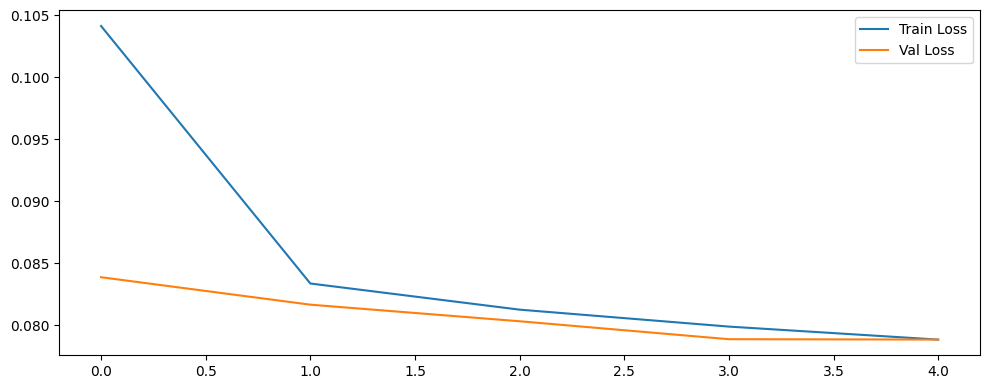

In [ ]:
import matplotlib.pyplot as plt

epoch_train_loss = [x[0]['avg_loss'] for x in results]
epoch_val_loss = [x[1]['avg_loss'] for x in results]

plt.figure(figsize=(10, 4))
plt.plot(epoch_train_loss, label='Train Loss')
plt.plot(epoch_val_loss, label='Val Loss')

plt.tight_layout()
plt.legend()
plt.show()

### Generate samples

In [ ]:
def generate(model, width, height, num_samples, display_bar=True):
    if display_bar:
        bar = tqdm(total=width*height, desc='Generating', postfix='', leave=True, position=0)

    with torch.no_grad():
        res = torch.zeros(num_samples, 1, width, height).to(device)
        for i in range(width):
            for j in range(height):
                out = model(res)[:, :, i, j]
                res[:, :, i, j] = torch.bernoulli(out)
                if display_bar: bar.update(1)
        if display_bar: del bar
    return res

num_samples = 100
results = generate(model, 28, 28, num_samples)

Generating: 100%|██████████| 784/784 [00:18<00:00, 42.43it/s]


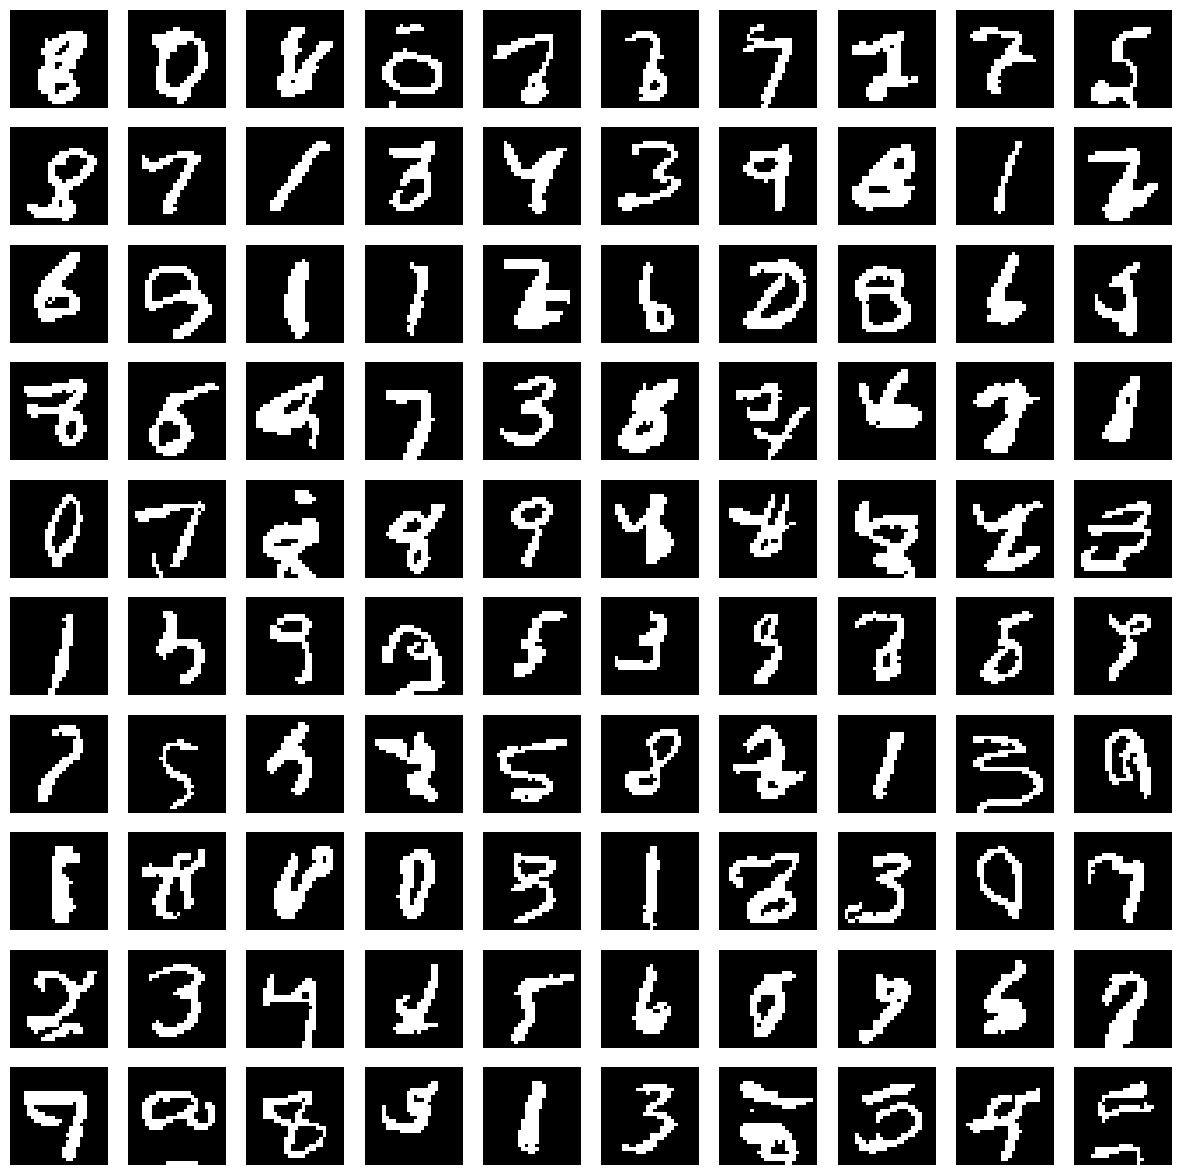

In [ ]:
fig, axes = plt.subplots(10, 10, figsize=(15, 15))
axes = axes.ravel()
for i in range(num_samples):
    axes[i].imshow(results[i].squeeze().cpu(), cmap='gray')
    axes[i].axis('off')
plt.show()